<a href="https://colab.research.google.com/github/Prem926/indian-monument-classifier-using-cvdl/blob/main/cvdlproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # This will open a file upload dialog in Colab


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import zipfile
import os

# List files in the current directory to ensure 'archive (5).zip' is present and correctly named
print(os.listdir('/content/'))

# Unzipping the uploaded dataset
# If the file name is different, adjust it here
with zipfile.ZipFile('/content/drive/MyDrive/archive (5).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Verify the extracted folders
print(os.listdir('/content/'))


['.config', 'drive', 'sample_data']
['.config', 'Indian-monuments', 'drive', 'sample_data']


In [ ]:
print("Train subfolders:", os.listdir('/content/Indian-monuments/images/train'))
print("Test subfolders:", os.listdir('/content/Indian-monuments/images/test'))


Train subfolders: ['tanjavur temple', 'tajmahal', 'victoria memorial', 'Ajanta Caves', 'jamali_kamali_tomb', 'Ellora Caves', 'charminar', 'Sun Temple Konark', 'basilica_of_bom_jesus', 'Gateway of India', 'qutub_minar', 'Fatehpur Sikri', 'Charar-E- Sharif', 'hawa mahal pics', 'alai_darwaza', 'India gate pics', 'mysore_palace', 'Humayun_s Tomb', 'lotus_temple', 'Khajuraho', 'iron_pillar', 'golden temple', 'Chhota_Imambara', 'alai_minar']
Test subfolders: ['India_gate', 'tanjavur temple', 'tajmahal', 'Hawa mahal', 'victoria memorial', 'Ajanta Caves', 'jamali_kamali_tomb', 'Ellora Caves', 'charminar', 'Sun Temple Konark', 'basilica_of_bom_jesus', 'Gateway of India', 'qutub_minar', 'Fatehpur Sikri', 'Charar-E- Sharif', 'alai_darwaza', 'mysore_palace', 'Humayun_s Tomb', 'lotus_temple', 'Khajuraho', 'iron_pillar', 'golden temple', 'Chhota_Imambara', 'alai_minar']


In [ ]:
!pip install tensorflow wikipedia-api


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14347 sha256=cdc8588be8c259eab62a4b654bd1bdbae349f340d0876fa8ecf24432e19853dd
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [ ]:
!pip install pyttsx3 folium

In [ ]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import cv2
from google.colab import files

# Step 1: Setup Paths and Data Augmentation
train_path = '/content/Indian-monuments/images/train'
test_path = '/content/Indian-monuments/images/test'

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_path, target_size=(150, 150), batch_size=32, class_mode='categorical')
test_data = test_gen.flow_from_directory(test_path, target_size=(150, 150), batch_size=32, class_mode='categorical')

# Step 2: Building the Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Step 3: Training the Model
history = model.fit(train_data, epochs=10, validation_data=test_data)

# Step 4: Upload or Capture Image for Prediction
def predict_image(img_path):
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction[0])
    class_name = list(train_data.class_indices.keys())[class_idx]

    print(f"Predicted Site: {class_name}")
    return class_name

# Step 5: Fetch Additional Info from Wikipedia
def fetch_wikipedia_info(heritage_site):
    url = f"https://en.wikipedia.org/wiki/{heritage_site.replace(' ', '_')}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract the first paragraph from Wikipedia
    paras = soup.find_all('p')
    for para in paras:
        if para.text.strip():
            print(f"\nMore about {heritage_site}:\n", para.text.strip())
            break

# Upload and Predict Example
uploaded = files.upload()
for file_name in uploaded.keys():
    heritage_name = predict_image(file_name)
    fetch_wikipedia_info(heritage_name)

# Plot Training Accuracy and Loss
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_metrics(history)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Indian-monuments/images/train'

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=d154c81c0d084104e2bc2ffb464042108037f2b89625902b4fb6602ac25b8f86
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


Found 2942 images belonging to 24 classes.
Found 724 images belonging to 24 classes.
Found 1049 images belonging to 24 classes.


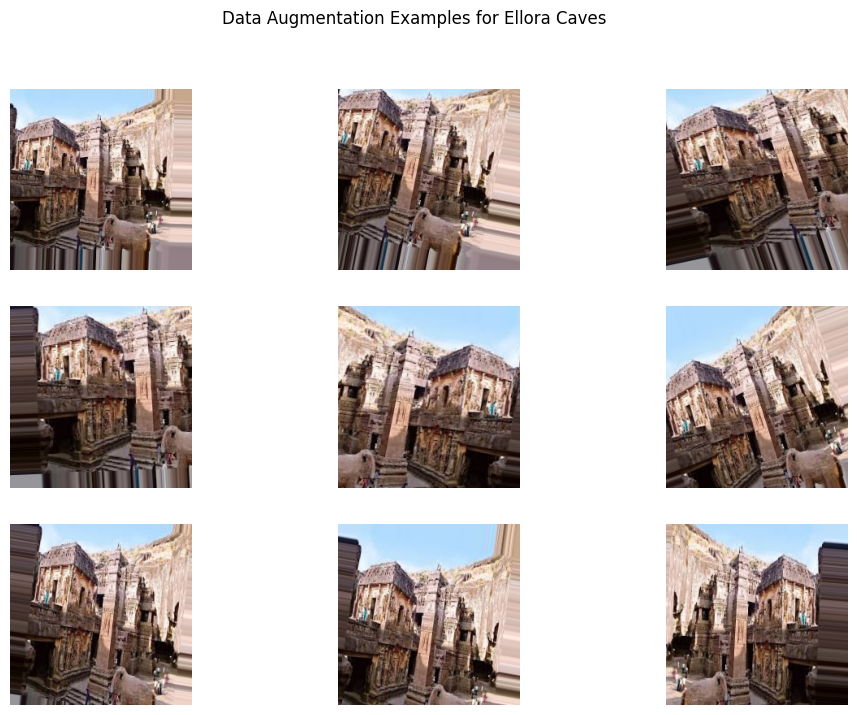

Epoch 1/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.4461 - loss: 2.0322
Epoch 1: val_accuracy improved from -inf to 0.85083, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 124s 951ms/step - accuracy: 0.4495 - loss: 2.0188 - val_accuracy: 0.8508 - val_loss: 0.5324 - learning_rate: 0.0010
Epoch 2/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8295 - loss: 0.5873
Epoch 2: val_accuracy improved from 0.85083 to 0.87569, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 120s 831ms/step - accuracy: 0.8295 - loss: 0.5871 - val_accuracy: 0.8757 - val_loss: 0.4070 - learning_rate: 0.0010
Epoch 3/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.8648 - loss: 0.4218
Epoch 3: val_accuracy improved from 0.87569 to 0.89641, saving model to best_model.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 775ms/step - accuracy: 0.8648 - loss: 0.4219 - val_accuracy: 0.8964 - val_loss: 0.3233 - learning_rate: 0.0010
Epoch 4/20
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/ste

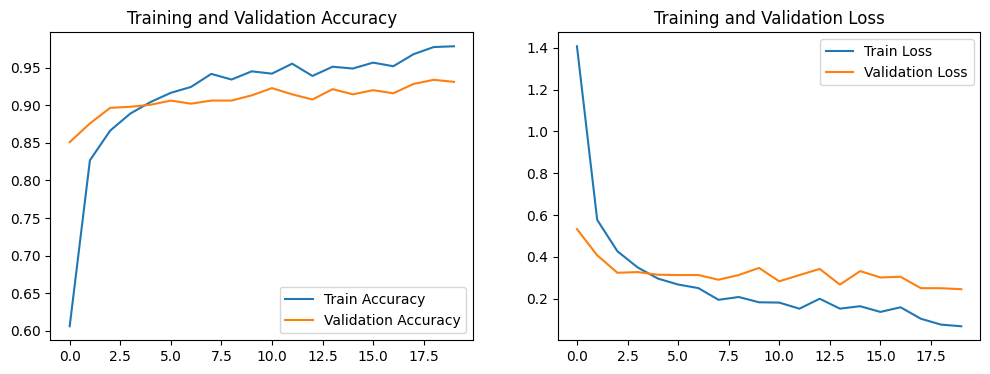

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 547ms/step


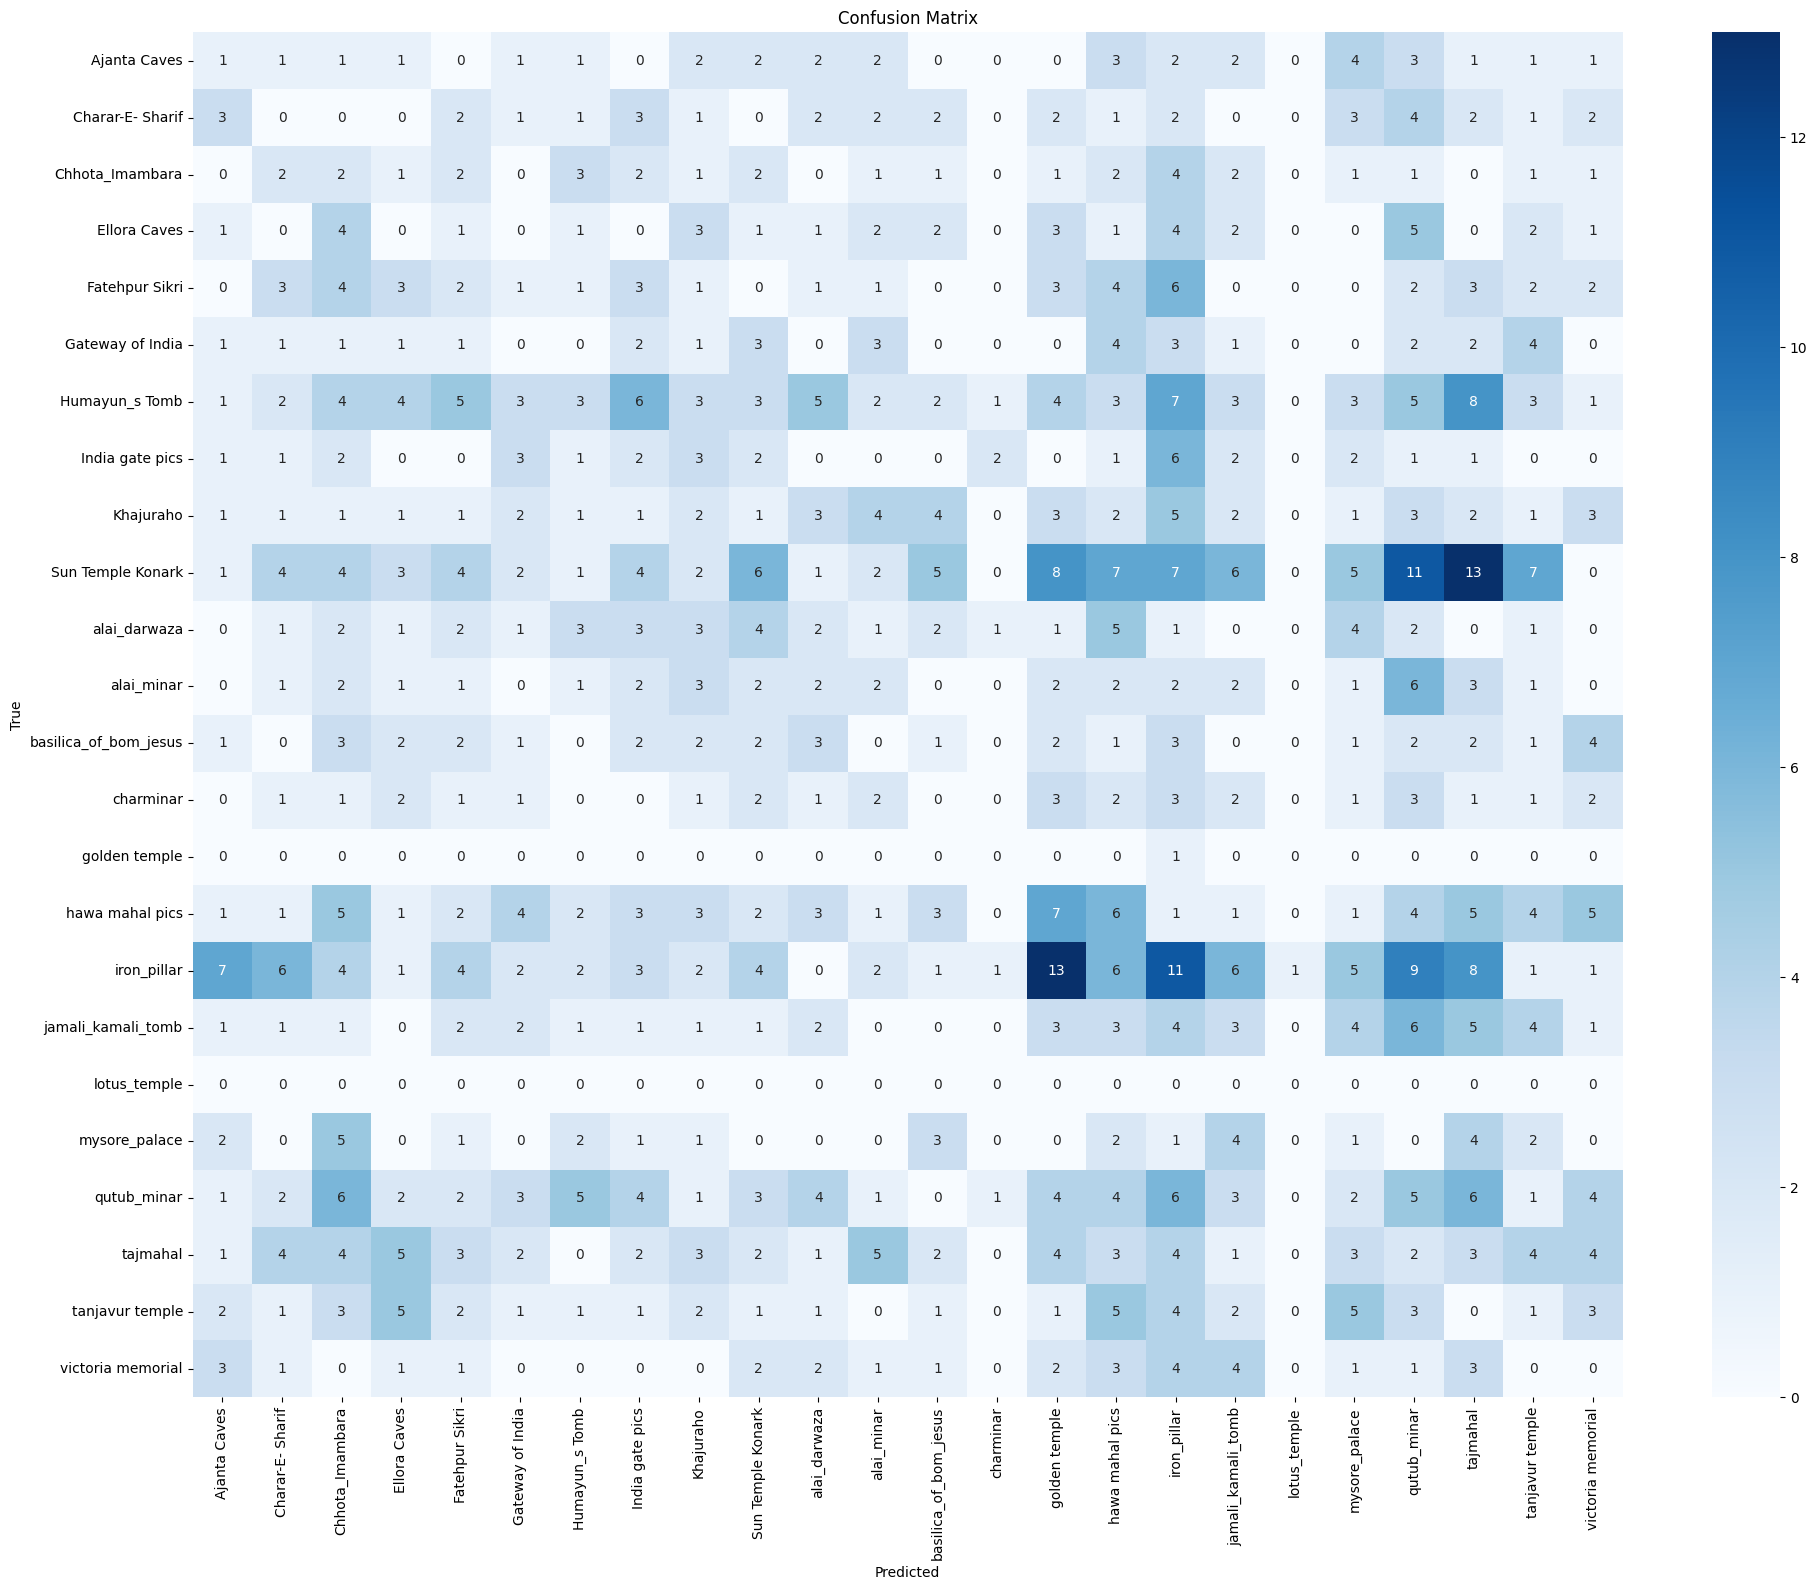

IndexError: index 30 is out of bounds for axis 0 with size 24

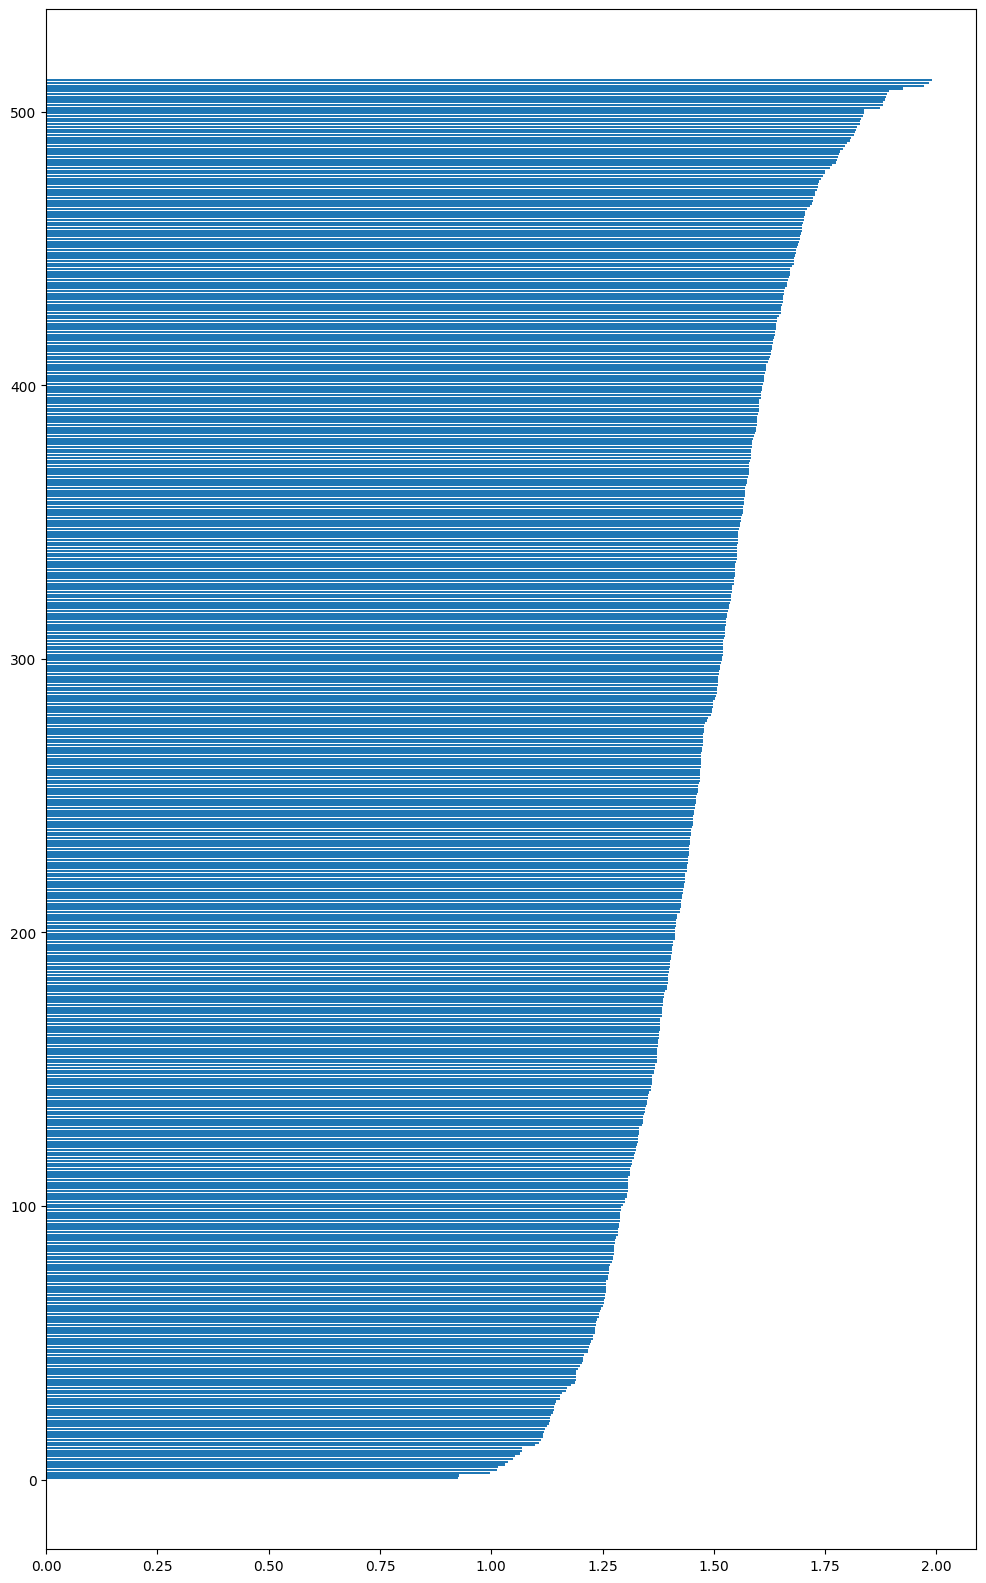

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import requests
from bs4 import BeautifulSoup
from google.colab import files
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import folium
from geopy.geocoders import Nominatim
from PIL import Image
import io
import wikipedia
import random
from tensorflow.keras.applications.efficientnet import preprocess_input

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # Reduced from 50 to 20
NUM_CLASSES = 24  # Updated to match the number of classes in your dataset

# Load and preprocess data
def load_data(train_dir, test_dir):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

# Build model
def build_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model
def train_model(model, train_generator, val_generator):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    return history

# Plot training metrics
def plot_training_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Grad-CAM visualization
def grad_cam(model, img_array, pred_index):
    grad_model = Model([model.inputs], [model.get_layer('top_activation').output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Fetch detailed information
def fetch_detailed_info(query):
    try:
        page = wikipedia.page(query)
        summary = wikipedia.summary(query, sentences=5)
        url = page.url
        return summary, url
    except:
        return f"No detailed information found for {query}", ""

# Predict and visualize
def predict_and_visualize(model, img_path, class_names):
    try:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array)
        pred_index = np.argmax(predictions[0])
        pred_class = class_names[pred_index]
        confidence = predictions[0][pred_index] * 100

        # Grad-CAM
        heatmap = grad_cam(model, img_array, pred_index)

        # Superimpose heatmap on original image
        heatmap = cv2.resize(heatmap, IMG_SIZE)
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

        # Display results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(superimposed_img)
        plt.title("Grad-CAM Visualization")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.bar(range(5), sorted(predictions[0])[-5:])
        plt.title("Top 5 Predictions")
        plt.xticks(range(5), [class_names[i] for i in np.argsort(predictions[0])[-5:]], rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

        # Fetch and display detailed information
        info, url = fetch_detailed_info(pred_class)
        print(f"\nPredicted: {pred_class} (Confidence: {confidence:.2f}%)")
        print(f"\nInformation about {pred_class}:\n{info}")
        print(f"\nFor more information: {url}")

        return pred_class, confidence
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, 0

# Confusion matrix visualization
def plot_confusion_matrix(model, test_generator, class_names):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Geolocation mapping
def plot_heritage_sites_map(class_names):
    geolocator = Nominatim(user_agent="heritage_app")
    m = folium.Map(location=[20, 78], zoom_start=4)

    for site in class_names:
        try:
            location = geolocator.geocode(f"{site}, India")
            if location:
                folium.Marker([location.latitude, location.longitude], popup=site).add_to(m)
        except:
            print(f"Could not locate {site}")

    return m

# Data augmentation visualization
def visualize_augmentations(datagen, train_dir, class_names):
    # Try to find a valid image
    for _ in range(10):  # Try up to 10 times
        try:
            random_class = random.choice(class_names)
            class_dir = os.path.join(train_dir, random_class)
            random_image = random.choice(os.listdir(class_dir))
            img_path = os.path.join(class_dir, random_image)

            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, 0)

            plt.figure(figsize=(12, 8))
            for i in range(9):
                aug_img = datagen.random_transform(img_array[0])
                plt.subplot(3, 3, i+1)
                plt.imshow(aug_img / 255)
                plt.axis('off')
            plt.suptitle(f'Data Augmentation Examples for {random_class}')
            plt.show()
            return
        except Exception as e:
            print(f"Error loading image: {str(e)}. Trying another...")

    print("Could not load any images for augmentation visualization.")

# Feature importance visualization
def visualize_feature_importance(model, class_names):
    weights = model.layers[-1].get_weights()[0]
    importance = np.sum(np.abs(weights), axis=1)
    sorted_idx = np.argsort(importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(12, 20))
    plt.barh(pos, importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(class_names)[sorted_idx])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Image preprocessing
def preprocess_image(img_path):
    try:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    train_dir = "/content/Indian-monuments/images/train"
    test_dir = "/content/Indian-monuments/images/test"
    train_generator, val_generator, test_generator = load_data(train_dir, test_dir)
    class_names = list(train_generator.class_indices.keys())

    # Ensure NUM_CLASSES matches the actual number of classes
    assert NUM_CLASSES == len(class_names), f"NUM_CLASSES ({NUM_CLASSES}) does not match the number of classes in the dataset ({len(class_names)})"

    # Visualize data augmentations
    visualize_augmentations(train_generator.image_data_generator, train_dir, class_names)

    # Build and train model
    model = build_model(NUM_CLASSES)
    history = train_model(model, train_generator, val_generator)

    # Print the number of epochs the model actually trained for
    print(f"Model trained for {len(history.history['loss'])} epochs")

    # Plot training metrics
    plot_training_metrics(history)

    # Plot confusion matrix
    plot_confusion_matrix(model, test_generator, class_names)

    # Visualize feature importance
    visualize_feature_importance(model, class_names)

    # Plot heritage sites map
    heritage_map = plot_heritage_sites_map(class_names)
    display(heritage_map)

    # User image classification
    while True:
        print("\nUpload an image for classification (or type 'exit' to quit):")
        try:
            uploaded = files.upload()
            if not uploaded:
                user_input = input().strip().lower()
                if user_input == 'exit':
                    break
                else:
                    print("No file uploaded. Please try again.")
                    continue

            for filename in uploaded.keys():
                img_path = filename
                preprocessed_img = preprocess_image(img_path)
                if preprocessed_img is not None:
                    pred_class, confidence = predict_and_visualize(model, img_path, class_names)
                    if pred_class is None:
                        print("Please upload a different image.")
                else:
                    print("Please upload a valid image file.")
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            print("Please try uploading a different image.")

    print("Thank you for using the Indian Heritage Classifier!")


Found 2942 images belonging to 24 classes.
Found 724 images belonging to 24 classes.
Found 1049 images belonging to 24 classes.
Model loaded successfully. Ready for image classification.

Upload an image for classification (or type 'exit' to quit):


Saving charminar.jpeg to charminar (3).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


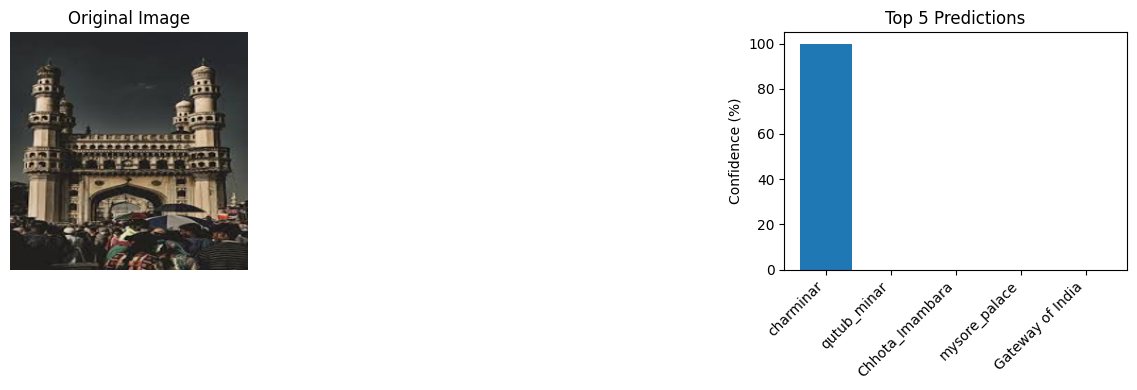


Predicted: charminar
Confidence: 100.00%

Information about charminar:
The Charminar (lit. 'four minarets') is a monument located in Hyderabad, Telangana, India. Constructed in 1591, the landmark is a symbol of Hyderabad and officially incorporated in the emblem of Telangana. The Charminar's long history includes the existence of a mosque on its top floor for more than 425 years.

Upload an image for classification (or type 'exit' to quit):


good
No file uploaded. Please try again.

Upload an image for classification (or type 'exit' to quit):


KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import requests
from bs4 import BeautifulSoup
from google.colab import files
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import folium
from geopy.geocoders import Nominatim
from PIL import Image
import io
import wikipedia
import random
from tensorflow.keras.applications.efficientnet import preprocess_input

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # Reduced from 50 to 20
NUM_CLASSES = 24  # Updated to match the number of classes in your dataset

# Load and preprocess data
def load_data(train_dir, test_dir):
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_generator = datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

# Build model
def build_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model
def train_model(model, train_generator, val_generator):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

    return history

# Plot training metrics
def plot_training_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Grad-CAM visualization
def grad_cam(model, img_array, pred_index):
    grad_model = Model([model.inputs], [model.get_layer('top_activation').output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Fetch detailed information
def fetch_detailed_info(query):
    try:
        page = wikipedia.page(query)
        summary = wikipedia.summary(query, sentences=5)
        url = page.url
        return summary, url
    except:
        return f"No detailed information found for {query}", ""

# Predict and visualize
def predict_and_visualize(model, img_path, class_names):
    try:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        predictions = model.predict(img_array)
        pred_index = np.argmax(predictions[0])
        pred_class = class_names[pred_index]
        confidence = predictions[0][pred_index] * 100

        # Display original image
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Display top 5 predictions
        plt.subplot(1, 3, 3)
        top_5_indices = np.argsort(predictions[0])[-5:][::-1]
        top_5_classes = [class_names[i] for i in top_5_indices]
        top_5_confidences = [predictions[0][i] * 100 for i in top_5_indices]

        plt.bar(range(5), top_5_confidences)
        plt.title("Top 5 Predictions")
        plt.xticks(range(5), top_5_classes, rotation=45, ha='right')
        plt.ylabel('Confidence (%)')

        plt.tight_layout()
        plt.show()

        # Print prediction results
        print(f"\nPredicted: {pred_class}")
        print(f"Confidence: {confidence:.2f}%")

        # Fetch and display detailed information
        info = fetch_wikipedia_info(pred_class)
        print(f"\nInformation about {pred_class}:\n{info}")

        return pred_class, confidence
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        print("Details of the error:")
        import traceback
        traceback.print_exc()
        return None, 0

# Fetch Wikipedia information
def fetch_wikipedia_info(query):
    try:
        page = wikipedia.page(query)
        summary = wikipedia.summary(query, sentences=3)
        return summary
    except:
        return f"No detailed information found for {query}"

# Confusion matrix visualization
def plot_confusion_matrix(model, test_generator, class_names):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Geolocation mapping
def plot_heritage_sites_map(class_names):
    geolocator = Nominatim(user_agent="heritage_app")
    m = folium.Map(location=[20, 78], zoom_start=4)

    for site in class_names:
        try:
            location = geolocator.geocode(f"{site}, India")
            if location:
                folium.Marker([location.latitude, location.longitude], popup=site).add_to(m)
        except:
            print(f"Could not locate {site}")

    return m

# Data augmentation visualization
def visualize_augmentations(datagen, train_dir, class_names):
    # Try to find a valid image
    for _ in range(10):  # Try up to 10 times
        try:
            random_class = random.choice(class_names)
            class_dir = os.path.join(train_dir, random_class)
            random_image = random.choice(os.listdir(class_dir))
            img_path = os.path.join(class_dir, random_image)

            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, 0)

            plt.figure(figsize=(12, 8))
            for i in range(9):
                aug_img = datagen.random_transform(img_array[0])
                plt.subplot(3, 3, i+1)
                plt.imshow(aug_img / 255)
                plt.axis('off')
            plt.suptitle(f'Data Augmentation Examples for {random_class}')
            plt.show()
            return
        except Exception as e:
            print(f"Error loading image: {str(e)}. Trying another...")

    print("Could not load any images for augmentation visualization.")

# Feature importance visualization
def visualize_feature_importance(model, class_names):
    weights = model.layers[-1].get_weights()[0]
    importance = np.sum(np.abs(weights), axis=1)
    sorted_idx = np.argsort(importance)
    pos = np.arange(len(class_names)) + .5

    plt.figure(figsize=(12, 20))
    plt.barh(pos, importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(class_names)[sorted_idx])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Image preprocessing
def preprocess_image(img_path):
    try:
        img = Image.open(img_path)
        img = img.convert('RGB')
        img = img.resize(IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    # Load data and class names
    train_dir = "/content/Indian-monuments/images/train"
    test_dir = "/content/Indian-monuments/images/test"
    train_generator, val_generator, test_generator = load_data(train_dir, test_dir)
    class_names = list(train_generator.class_indices.keys())

    # Load the trained model
    # If you saved the model using ModelCheckpoint:
    model = load_model('best_model.keras')
    # Or if the model is still in memory, you can use the existing 'model' variable

    print("Model loaded successfully. Ready for image classification.")

    # User image classification
    while True:
        print("\nUpload an image for classification (or type 'exit' to quit):")
        try:
            uploaded = files.upload()
            if not uploaded:
                user_input = input().strip().lower()
                if user_input == 'exit':
                    break
                else:
                    print("No file uploaded. Please try again.")
                    continue

            for filename in uploaded.keys():
                img_path = filename
                preprocessed_img = preprocess_image(img_path)
                if preprocessed_img is not None:
                    pred_class, confidence = predict_and_visualize(model, img_path, class_names)
                    if pred_class is None:
                        print("Please upload a different image.")
                else:
                    print("Please upload a valid image file.")
        except Exception as e:
            print(f"An error occurred: {str(e)}")
            print("Please try uploading a different image.")

    print("Thank you for using the Indian Heritage Classifier!")


Streaming output truncated to the last 5000 lines.
                            34.jpg
                            12.jpg
                            21.jpg
                            33.jpg
                            2.jpg
                            10.jpg
                            41.jpg
                            32.jpg
                            44.jpg
                            26.jpg
                            20.jpg
                            25.jpg
                            17.jpg
                            37.jpg
                            4.jpg
                            23.jpg
                            1.jpg
                            15.jpg
                            5.jpg
                            18.jpg
                            3.jpg
                            14.jpg
                            39.jpg
                            6.jpg
                            8.jpg
                            16.jpg
                            mysore_palace/
   

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.1551 - loss: 2.9590 
Epoch 1: val_accuracy improved from -inf to 0.04398, saving model to indian_heritage_model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 2112s 19s/step - accuracy: 0.1567 - loss: 2.9547 - val_accuracy: 0.0440 - val_loss: 3.1653 - learning_rate: 1.0000e-04
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7419 - loss: 1.0520
Epoch 2: val_accuracy did not improve from 0.04398
98/98 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.7426 - loss: 1.0492 - val_accuracy: 0.0285 - val_loss: 3.1942 - learning_rate: 1.0000e-04
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9122 - loss: 0.3159
Epoch 3: val_accuracy improved from 0.04398 to 0.14230, saving model to indian_heritage_model.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.9123 - loss: 0.3155 - val_accuracy: 0.1423 - val_loss: 2.9217 - learning_rate: 1.0000e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9529 - loss: 0.

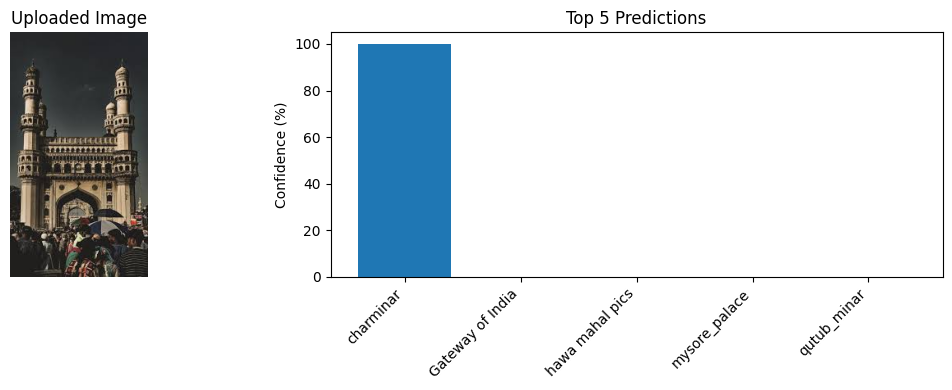


Predicted: charminar
Confidence: 100.00%

Information about charminar:
The Charminar (lit. 'four minarets') is a monument located in Hyderabad, Telangana, India. Constructed in 1591, the landmark is a symbol of Hyderabad and officially incorporated in the emblem of Telangana.[3] The Charminar's long history includes the existence of a mosque on its top floor for more than 425 years. While both historically and religiously significant, it is also known for its popular and busy local markets surrounding the structure, and has become one of the most frequented tourist attractions in Hyderabad. Charminar is also a site of numerous festival celebrations, such as Eid-ul-adha and Eid al-Fitr,[4] as it is adjacent to the city's main mosque, the Makkah Masjid.

Upload an image for classification (or type 'exit' to quit):
quit
File not found. Please provide a valid file path.

Upload an image for classification (or type 'exit' to quit):
exit
Thank you for using the Indian Heritage Classifier!


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
from io import BytesIO
import cv2
import random

# Constants
IMG_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 20  # Reduced from 100 to 20
NUM_CLASSES = 24  # Adjusted based on your dataset

def build_model(num_classes):
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

def predict_and_visualize(model, img_path, class_names):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions[0])
    pred_class = class_names[pred_index]
    confidence = predictions[0][pred_index] * 100

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(img_path))
    plt.title("Uploaded Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    top_5_indices = np.argsort(predictions[0])[-5:][::-1]
    top_5_classes = [class_names[i] for i in top_5_indices]
    top_5_confidences = [predictions[0][i] * 100 for i in top_5_indices]

    plt.bar(range(5), top_5_confidences)
    plt.title("Top 5 Predictions")
    plt.xticks(range(5), top_5_classes, rotation=45, ha='right')
    plt.ylabel('Confidence (%)')

    plt.tight_layout()
    plt.show()

    print(f"\nPredicted: {pred_class}")
    print(f"Confidence: {confidence:.2f}%")

    return pred_class, confidence

def fetch_web_info(query):
    try:
        url = f"https://en.wikipedia.org/wiki/{query.replace(' ', '_')}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        paragraphs = soup.find_all('p')
        for p in paragraphs:
            if len(p.text.strip()) > 100:
                return p.text.strip()
        return "No information found."
    except:
        return f"Unable to fetch information for {query}"

def fetch_similar_images(query, num_images=5):
    url = f"https://www.google.com/search?q={query}&tbm=isch"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    img_tags = soup.find_all('img')
    img_urls = [img['src'] for img in img_tags[1:num_images+1]]  # Skip first image (Google logo)
    return img_urls

def compare_images(img1_path, img2_url):
    img1 = cv2.imread(img1_path)
    img1 = cv2.resize(img1, IMG_SIZE)
    img1 = img1.flatten()

    response = requests.get(img2_url)
    img2 = Image.open(BytesIO(response.content))
    img2 = img2.resize(IMG_SIZE)
    img2 = np.array(img2)
    img2 = img2.flatten()

    similarity = cosine_similarity([img1], [img2])[0][0]
    return similarity

def augment_dataset(train_dir):
    for class_dir in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_dir)
        if os.path.isdir(class_path):
            img_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            if len(img_files) < 100:  # Augment if less than 100 images
                num_to_generate = 100 - len(img_files)
                for i in range(num_to_generate):
                    source_img = Image.open(os.path.join(class_path, random.choice(img_files)))
                    augmented_img = data_augmentation(source_img)
                    augmented_img.save(os.path.join(class_path, f'augmented_{i}.jpg'))

def data_augmentation(img):
    # Apply random transformations
    if random.choice([True, False]):
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.choice([True, False]):
        img = img.rotate(random.uniform(-20, 20))
    return img

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

# Main execution
if __name__ == "__main__":
    # Print current working directory and its contents
    print("Current working directory:", os.getcwd())
    print("\nDirectory structure:")
    print_directory_structure(os.getcwd())

    # Try to find the correct path for the dataset
    possible_paths = [
        "/content/Indian-monuments/images/train",
        "/content/Indian-monuments/train",
        "/content/Indian-monuments",
        "/content/train",
        "Indian-monuments/images/train",
        "Indian-monuments/train",
        "train"
    ]

    train_dir = None
    for path in possible_paths:
        if os.path.exists(path):
            train_dir = path
            break

    if train_dir is None:
        print("Could not find the training directory. Please provide the correct path:")
        train_dir = input().strip()

    print(f"Using training directory: {train_dir}")

    # Verify the directory exists before proceeding
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"The directory {train_dir} does not exist.")

    # Augment dataset (only if needed)
    # augment_dataset(train_dir)  # Commented out for now

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest',
        validation_split=0.2  # Use 20% of training data for validation
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,  # Use the same directory as training
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

    class_names = list(train_generator.class_indices.keys())
    NUM_CLASSES = len(class_names)

    # Load or train model
    model_path = 'indian_heritage_model.keras'
    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Loaded existing model.")
    else:
        print("Training new model...")
        model = build_model(NUM_CLASSES)
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
        checkpoint = ModelCheckpoint(
            model_path,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )

        history = model.fit(
            train_generator,
            epochs=EPOCHS,
            validation_data=val_generator,
            callbacks=[early_stopping, reduce_lr, checkpoint]
        )
        print("Model training complete and saved.")

    # Print the number of epochs the model actually trained for
    print(f"Model trained for {len(history.history['loss'])} epochs")

    # User image classification loop
    while True:
        print("\nUpload an image for classification (or type 'exit' to quit):")
        user_input = input().strip().lower()
        if user_input == 'exit':
            break

        if os.path.exists(user_input):
            pred_class, confidence = predict_and_visualize(model, user_input, class_names)

            if confidence < 50:
                print("The model is not confident about this image.")
                info = fetch_web_info(pred_class)
                print(f"\nPossible information about {pred_class}:\n{info}")

                print("\nSearching for similar images...")
                similar_images = fetch_similar_images(pred_class)
                max_similarity = 0
                most_similar_class = None
                for img_url in similar_images:
                    similarity = compare_images(user_input, img_url)
                    if similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_class = pred_class

                if most_similar_class:
                    print(f"\nMost similar class based on image comparison: {most_similar_class}")
                    info = fetch_web_info(most_similar_class)
                    print(f"\nInformation about {most_similar_class}:\n{info}")
            else:
                info = fetch_web_info(pred_class)
                print(f"\nInformation about {pred_class}:\n{info}")
        else:
            print("File not found. Please provide a valid file path.")

    print("Thank you for using the Indian Heritage Classifier!")


In [ ]:
!pip install --upgrade streamlit


2024-11-12 19:47:12.550 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.563 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.565 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.567 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.577 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.580 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-12 19:47:12.587 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar